#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорт библиотек

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

import time 
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import catboost as cb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

RND = 12345

### Загрузка и предобработка данных

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# проверка, что индекс монотонный
print(data.index.is_monotonic)

True


In [7]:
data.sort_index(inplace=True)

In [8]:
data = data.resample('1H').sum()

### Вывод

- Данные загружены
- Пропуски отсутсвуют
- Даты и время расположены в хронологическом порядке
- Данные ресемплированы по одному часу 

## Анализ

### Скользящее среднее

In [9]:
data_rolling = data.copy()
data_rolling = data_rolling.resample('1H').sum()
data_rolling['rolling_mean'] = data_rolling['num_orders'].shift().rolling(12).mean()
data_rolling['std'] = data_rolling['num_orders'].rolling(2).std()
data_rolling = data_rolling.dropna()

In [10]:
data_rolling.head(2)

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 12:00:00,30,57.083333,46.669048
2018-03-01 13:00:00,32,49.250000,1.414214


<AxesSubplot:title={'center':'Rolling mean'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

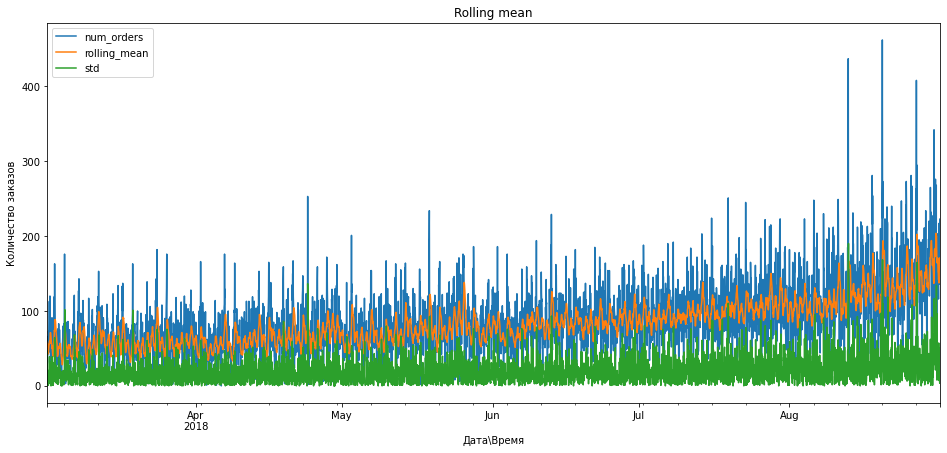

In [11]:
data_rolling[['num_orders', 'rolling_mean', 'std']].plot(title='Rolling mean',figsize=(16,7),xlabel='Дата\Время',ylabel='Количество заказов')

Среднее и стандартное отклонение меняются, значит временной ряд нестационарный

### Тренды и сезонность

<AxesSubplot:title={'center':'Trend'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

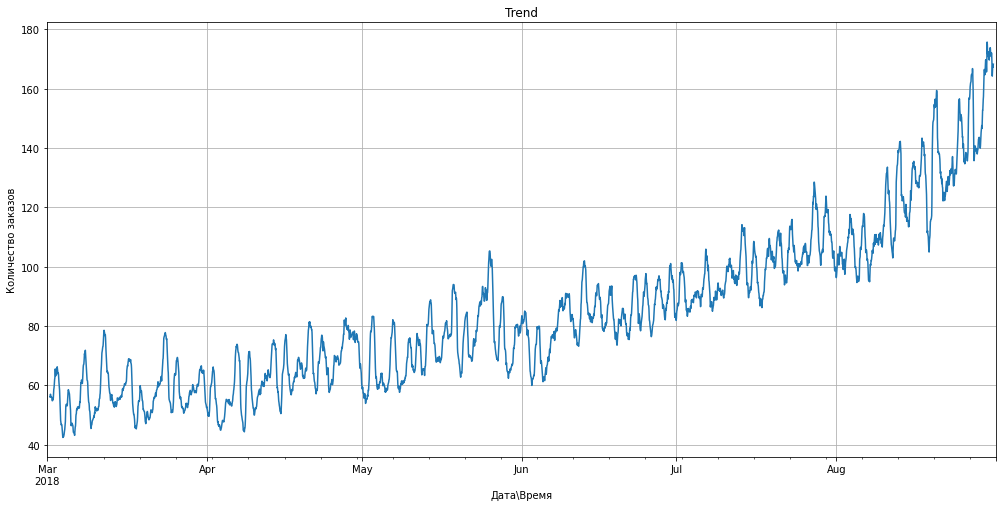

In [12]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(title='Trend', figsize = (17,8), grid=True, xlabel='Дата\Время', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Seasonal'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

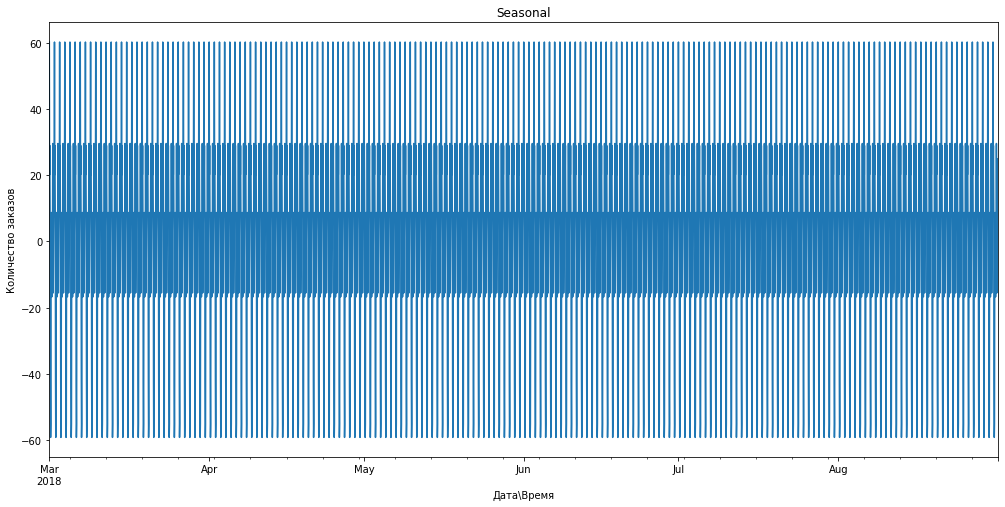

In [13]:
decomposed_data.seasonal.plot(title='Seasonal', figsize = (17,8), xlabel='Дата\Время', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Trend'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

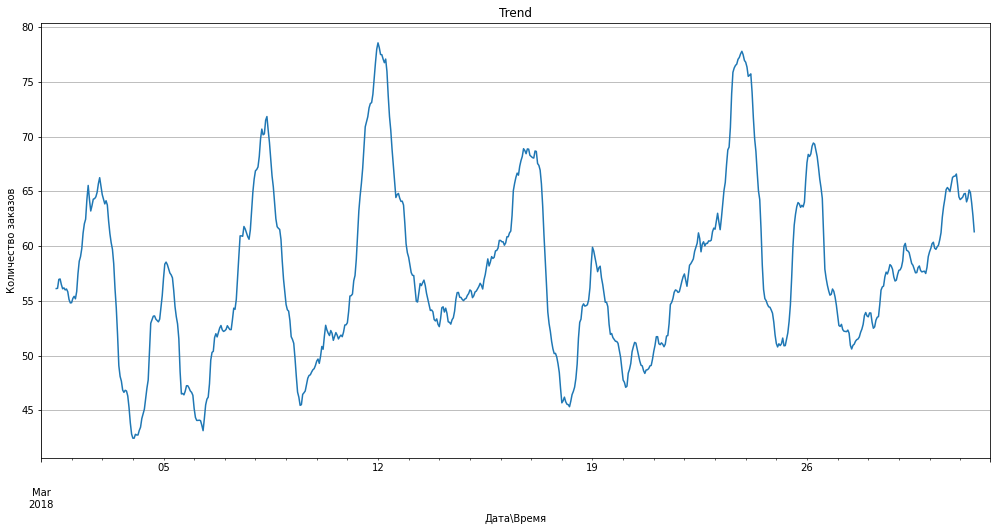

In [14]:
decomposed_data = seasonal_decompose(data['2018-03-01':'2018-03-31'])
decomposed_data.trend.plot(title='Trend', figsize = (17,8), grid=True, xlabel='Дата\Время', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Seasonal'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

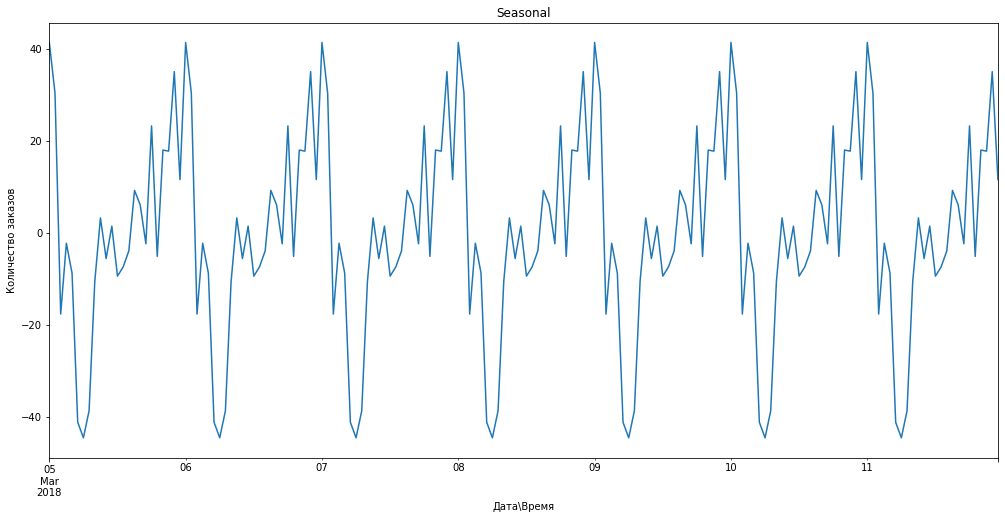

In [15]:
decomposed_data = seasonal_decompose(data['2018-03-05':'2018-03-11'])
decomposed_data.seasonal.plot(title='Seasonal', figsize = (17,8), xlabel='Дата\Время', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Trend'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

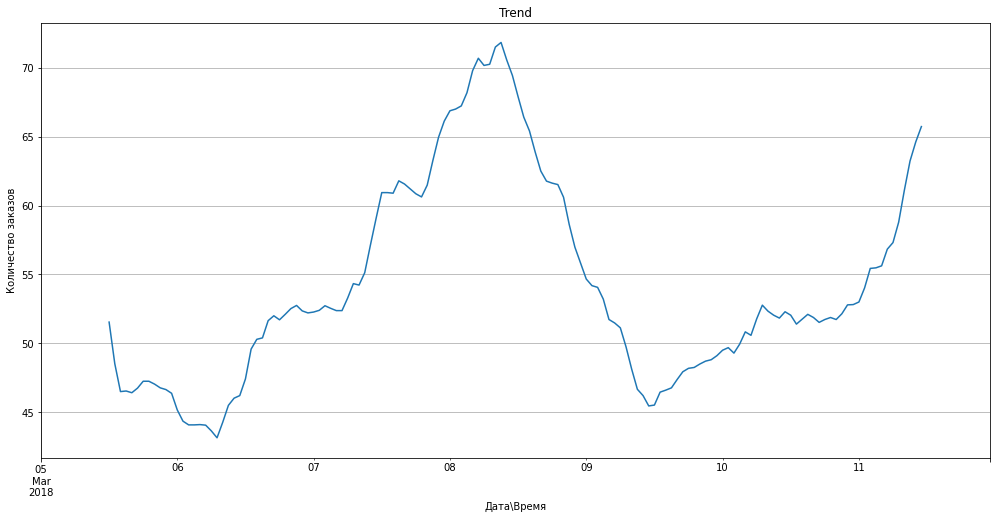

In [16]:
decomposed_data = seasonal_decompose(data['2018-03-05':'2018-03-11'])
decomposed_data.trend.plot(title='Trend', figsize = (17,8), grid=True, xlabel='Дата\Время', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Trend'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

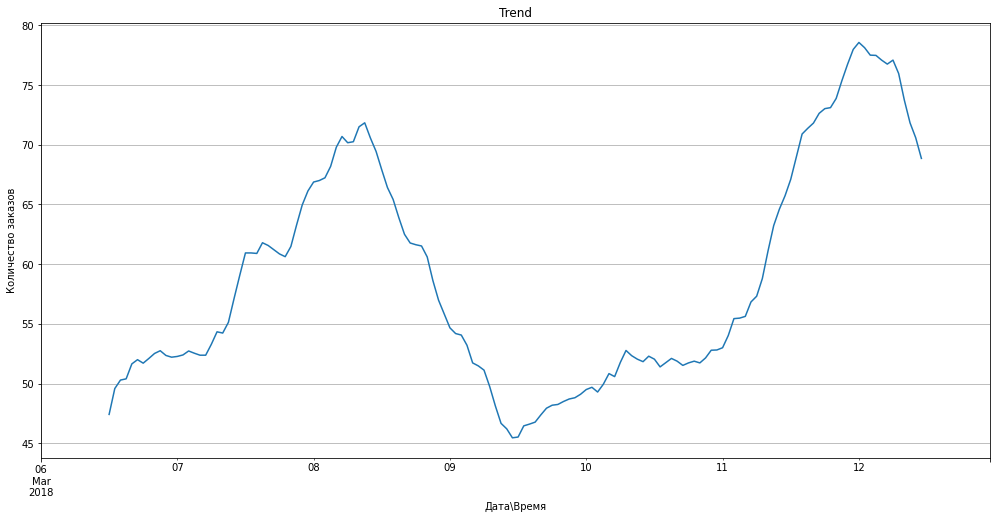

In [17]:
decomposed_data = seasonal_decompose(data['2018-03-06':'2018-03-12'])
decomposed_data.trend.plot(title='Trend', figsize = (17,8), grid=True, xlabel='Дата\Время', ylabel='Количество заказов')

<AxesSubplot:title={'center':'Trend'}, xlabel='Дата\\Время', ylabel='Количество заказов'>

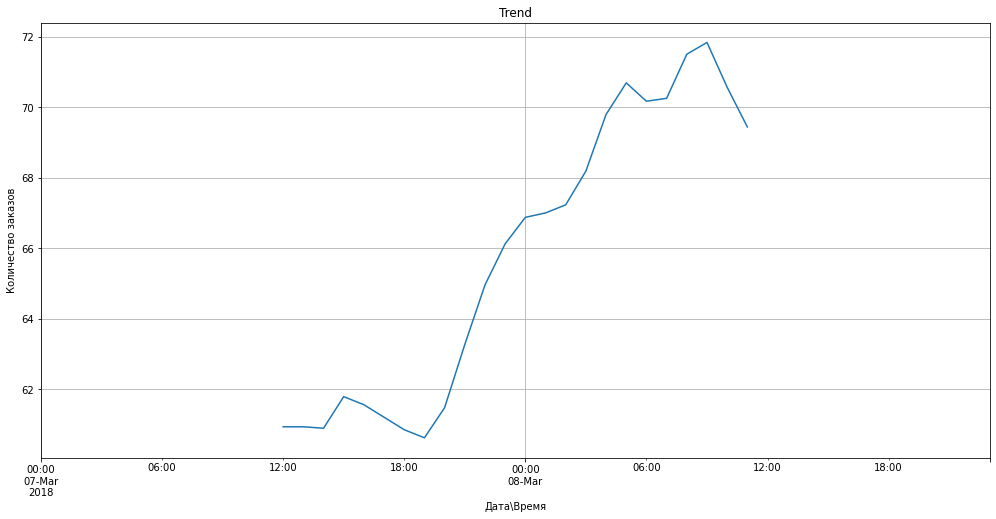

In [18]:
decomposed_data = seasonal_decompose(data['2018-03-07':'2018-03-8'])
decomposed_data.trend.plot(title='Trend', figsize = (17,8), grid=True, xlabel='Дата\Время', ylabel='Количество заказов')

### Вывод

Дисперсия постепенно растет, с каждым месяцем наблюдается рост заказов такси. В течении недели услуги такси наиболее востребованы в будние дни. Наиболее часто такси заказывают с 3 часов ночи и до 10 утра. Среднее и стандартное отклонение меняются, значит временной ряд нестационарный.

## Обучение

### Создание признаков

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [20]:
data_feat = data.copy()

In [21]:
make_features(data_feat, 24, 48)

### Разделение на выборки

In [22]:
train, test = train_test_split(data_feat, shuffle=False, test_size=0.1,random_state=RND)

In [23]:
train = train.dropna()
test = test.dropna()

In [24]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [25]:
print(
features_train.shape,
target_train.shape,
features_test.shape,
target_test.shape)

(3931, 29) (3931,) (437, 29) (437,)


In [26]:
print(features_train.index.min(), features_train.index.max())

2018-03-03 00:00:00 2018-08-13 18:00:00


In [27]:
print(features_test.index.min(), features_test.index.max())

2018-08-13 19:00:00 2018-08-31 23:00:00


Тренировочная и тестовая выборки имеют хронологически порядок

In [28]:
tscv = TimeSeriesSplit(n_splits=8)

### Линейная регресия

In [29]:
%%time
tscv = TimeSeriesSplit(n_splits=8)
regressor = LinearRegression()

RMSE_LinearRegression = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5

CPU times: user 235 ms, sys: 70.9 ms, total: 306 ms
Wall time: 44.2 ms


In [30]:
print('RMSE', "{:.3f}".format(RMSE_LinearRegression))

RMSE 26.837


### Случайный лес

In [31]:
rf_params = {
        'n_estimators' : range(50, 100, 10),
        'max_depth' : range(2, 20, 2),
        'verbose' : [0],
        'random_state' : [RND] 
        }

In [32]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'], 
                'max_depth':range(2, 20, 2), 
                'random_state':[RND]}]

rf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
rf.fit(features_train, target_train)

means = rf.cv_results_['mean_test_score']
stds = rf.cv_results_['std_test_score']

rf_best_params = rf.best_params_
RMSE_RandomForest = (max(means)*-1) ** 0.5

CPU times: user 1min 26s, sys: 1 s, total: 1min 27s
Wall time: 1min 26s


In [33]:
print('Лучшие гиперпараметры: ', rf_best_params)
print('RMSE', "{:.3f}".format(RMSE_RandomForest))

Лучшие гиперпараметры:  {'criterion': 'mse', 'max_depth': 18, 'random_state': 12345}
RMSE 24.272


### CatBoost

In [34]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[1515],
                'verbose':[False]}]

cb = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
cb.fit(features_train, target_train)

means = cb.cv_results_['mean_test_score']
stds = cb.cv_results_['std_test_score']

cb_best_params = cb.best_params_
RMSE_CatBoost = (max(means)*-1) ** 0.5

CPU times: user 1min 17s, sys: 20.2 s, total: 1min 37s
Wall time: 25.1 s


In [35]:
print('Лучшие гиперпараметры: ', cb_best_params)
print("RMSE:", "{:.3f}".format(RMSE_CatBoost))

Лучшие гиперпараметры:  {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
RMSE: 23.453


Показатели RMSE

In [36]:
columns = ['Модель','RMSE']
regression_model = ['Линейная регрессия', "{:.3f}".format(RMSE_LinearRegression)]
forest_model = ['Случайный лес', "{:.3f}".format(RMSE_RandomForest)]
cb_model = ['CatBoostRegressor', "{:.3f}".format(RMSE_CatBoost)]
table = pd.DataFrame([regression_model, forest_model, cb_model], columns = columns)

display(table)

,Модель,RMSE
0,Линейная регрессия,26.837
1,Случайный лес,24.272
2,CatBoostRegressor,23.453


Лучший RMSE `CatBoostRegressor` `23.45`

## Тестирование

### CatBoost

In [37]:
top_cb = CatBoostRegressor(**cb.best_params_)
top_cb.fit(features_train, target_train)
cb_test_pred = top_cb.predict(features_test)
RMSE_CatBoost_test = mean_squared_error(target_test, cb_test_pred)**0.5

In [38]:
print('RMSE:',"{:.2f}".format(RMSE_CatBoost_test))

RMSE: 40.15


Лучшее значение RMSE на тестовой выборке получил `CatBoostRegressor` `40.15`

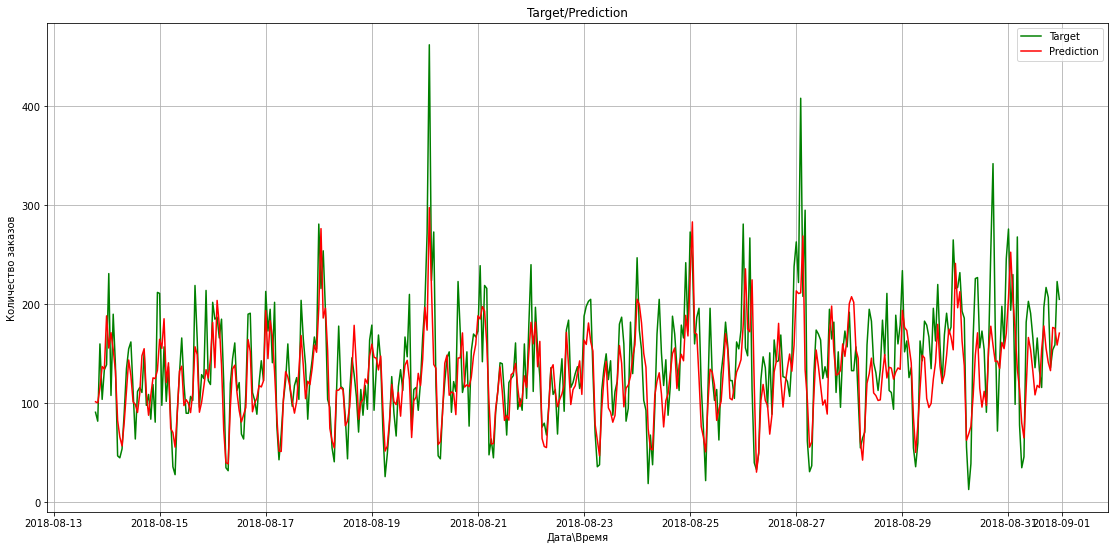

In [39]:
plt.figure(figsize=(19,9))
plt.grid(True)
plt.title('Target/Prediction')
plt.xlabel('Дата\Время')
plt.ylabel('Количество заказов')
plt.plot(target_test.index, target_test,'g-',
         target_test.index, cb_test_pred,'r-')
plt.legend(['Target','Prediction'])
plt.show()

## Вывод

Данные проанализированы ресемплированы по одному часу.

Дисперсия постепенно растет, с каждым месяцем наблюдается рост заказов такси. В течении недели услуги такси наиболее востребованы в будние дни. Наиболее часто такси заказывают с 3 часов ночи и до 10 утра. Среднее и стандартное отклонение меняются - временной ряд нестационарный.

Обучены три модели Линейная регресия, Случайный лес и CatBoost.

После проверки моделей на тестовой выборке,выбрана моель с лучшим RMSE 40.15 CatBoostRegressor